## A model of sequence-dependent mutations



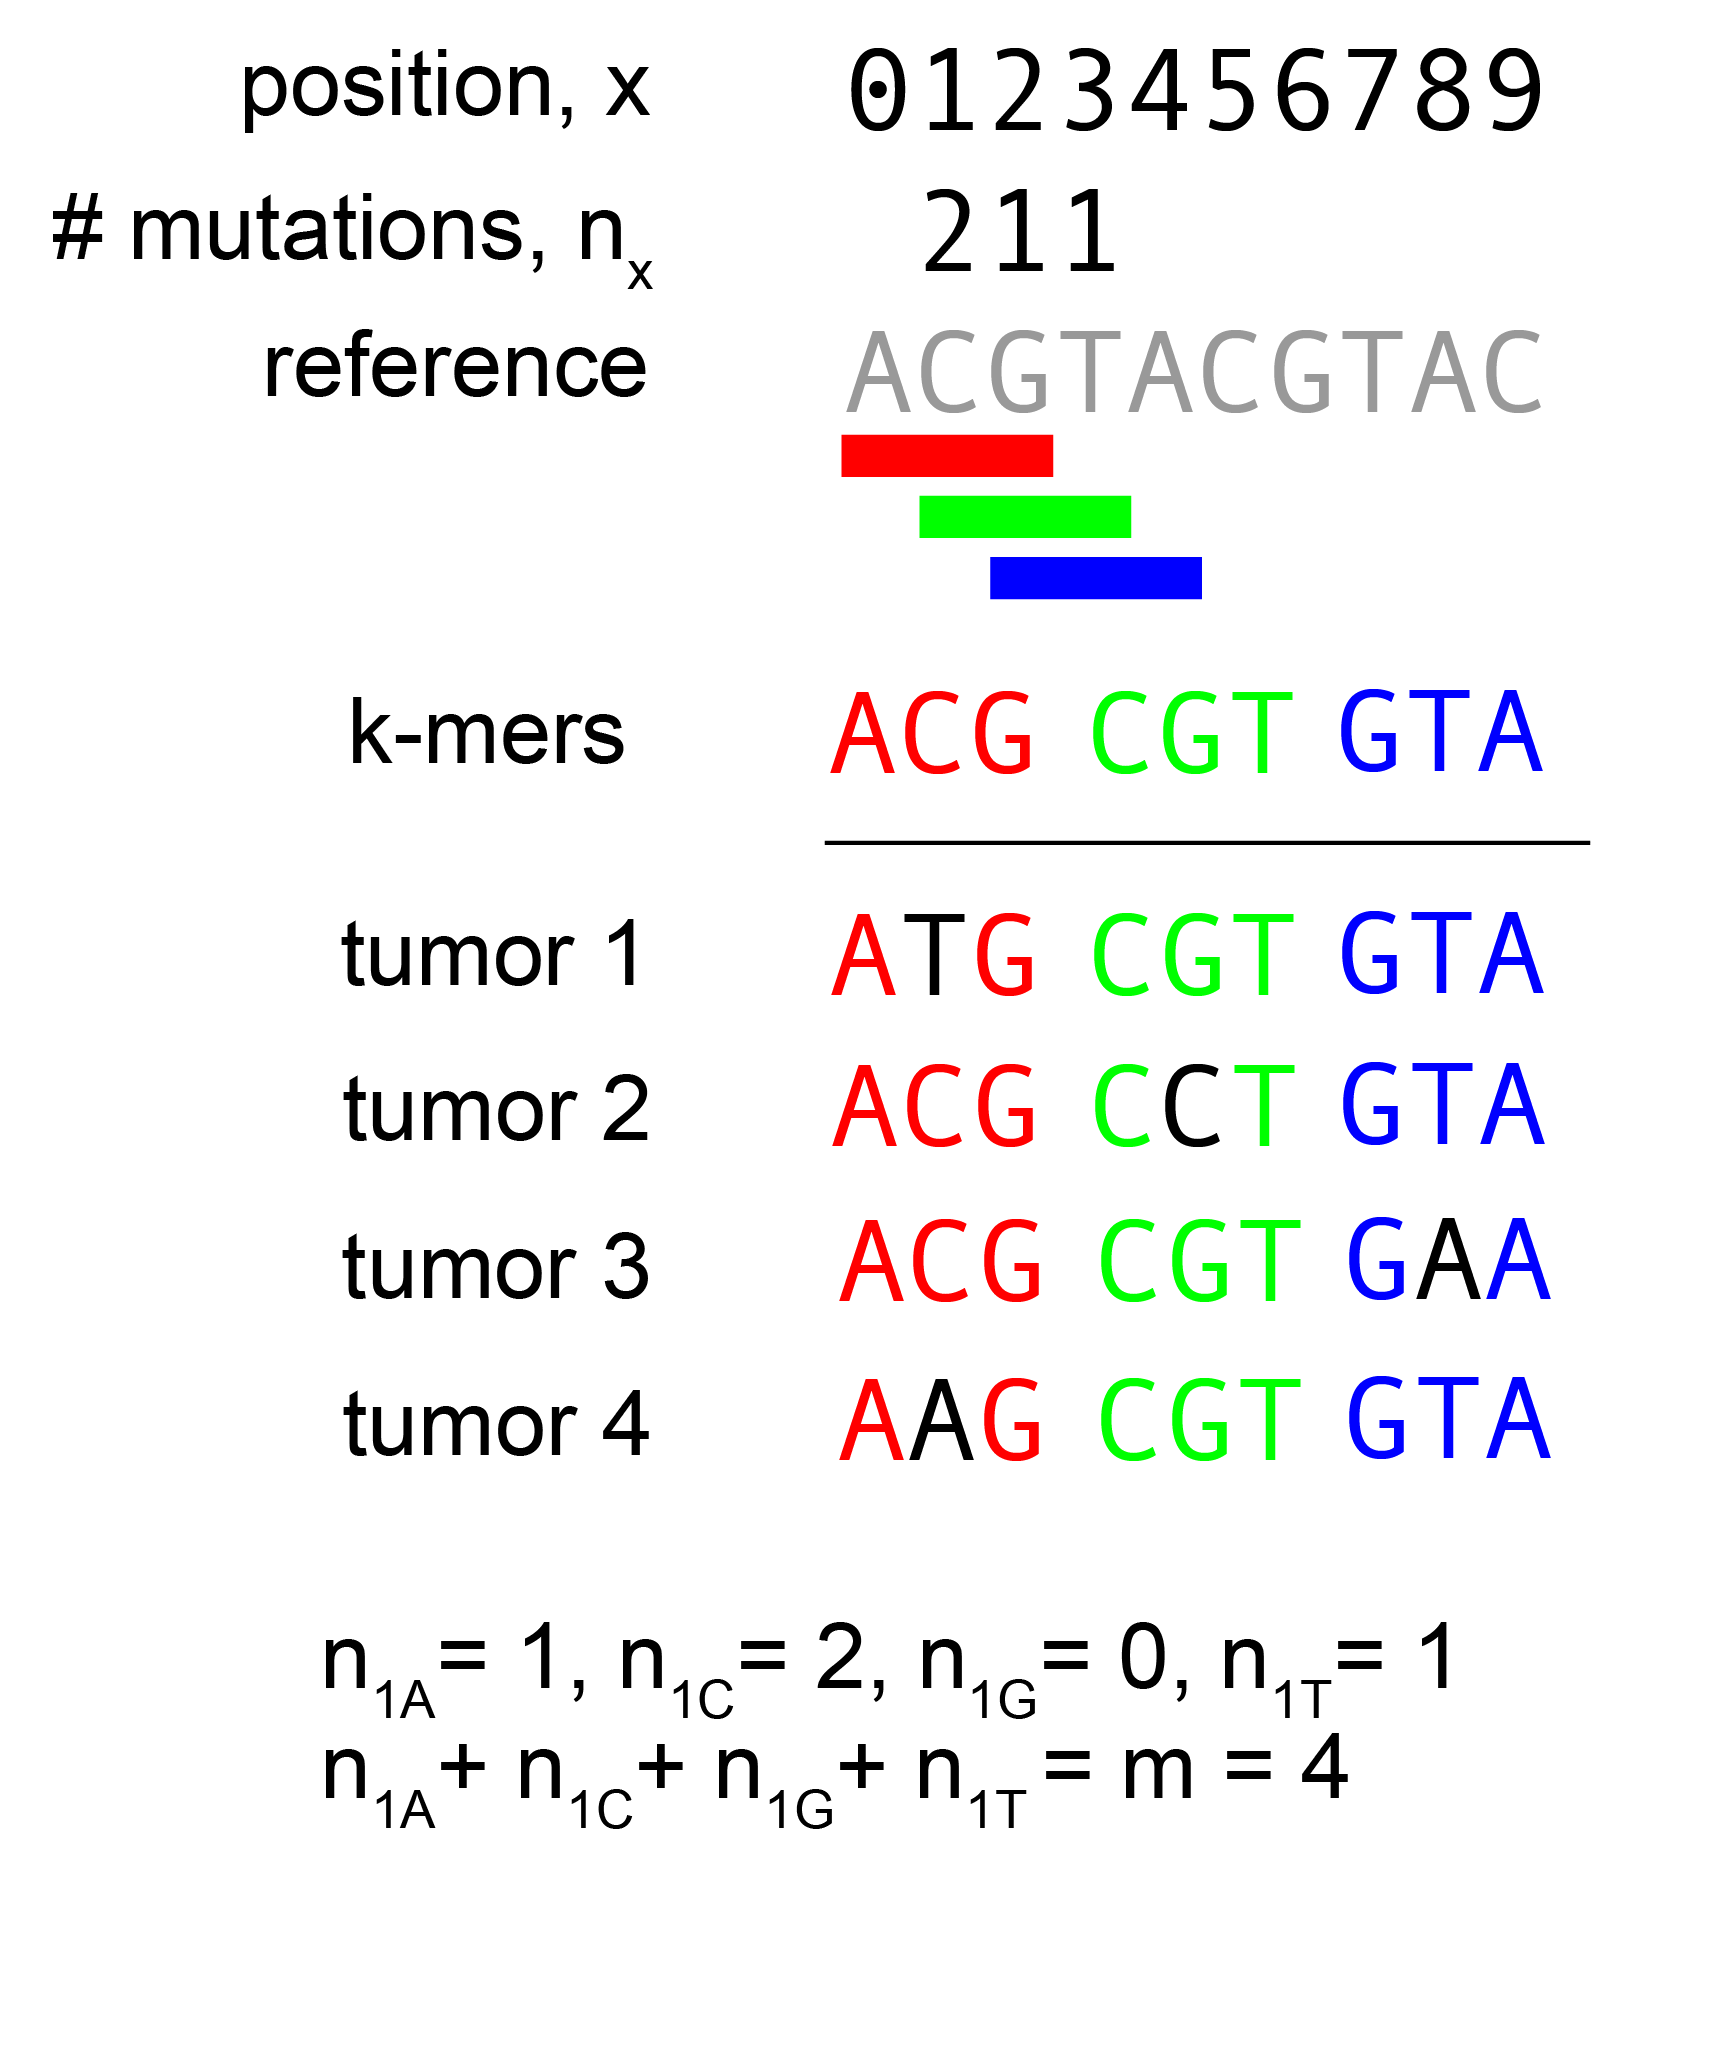

In [1]:
# embed raw image data in notebook: 
# https://github.com/microsoft/vscode-jupyter/issues/6437
from IPython.display import Image
Image(filename='model.png', width=400)

In [2]:
# math rendering doesn't work in vscode native jupyter notebooks yet: 
# https://github.com/microsoft/vscode-jupyter/issues/1216

Based upon Aggarwala and Voight 2016 https://www.nature.com/articles/ng.3511 

Assume that the probability $p_{x,b}$ that a given tumor genome has the base $b$ at site $x$ depends only upon local 
(reference) sequence context. That is, assume 

\begin{equation}
p_{x,b} = p_{f(x, k), \, b}, 
\end{equation}
where $f(x, k)$ is the reference subsequence of size $k$ centered at site $x$. 

Assume further the **independent sites approximation**:
mutations are so rare in an individual tumor that we may safely 
neglect the event where two or more mutations occur in k-mers that overlap each other in the reference 
genome. 

Under this model,
in a cohort of $m$ tumor genomes, the number at which the site $x$ is occupied by the base $b$, represented by $n_{x,b}$, is distributed according to:

\begin{equation} 
\mbox{Multinomial}(n_{x, A}, n_{x,C}, n_{x,G}, n_{x,T} \, | \, m, p_{f(x,k),\, A}, p_{f(x,k),\, C}, p_{f(x,k),\, G}, p_{f(x,k),\, T}) .
\end{equation} 

Similarly, in a genomic interval containing $l_{s}$ reference occurrences of the k-mer $s$, 
the number of occurrences in the tumor cohort, $n_{s, b}$, where the center nucleotide of $s$ is $b$ 
is distributed as: 

\begin{equation} 
\mbox{Multinomial}(n_{s, A}, n_{s,C}, n_{s,G}, n_{s,T} \, | \, ml_s, p_{s,\, A}, p_{s,\, C}, p_{s,\, G}, p_{s,\, T}) .
\end{equation} 

The mutation probability, $p_x$, at site $x$ is given by: 
\begin{equation} 
p_x = \sum_{b \neq g(f(x,k))} p_{f(x,k),\, b},
\end{equation}
where $g(s)$ is the center nucleotide of the k-mer $s$.

The number of mutations $N_x$ observed at site $x$ over all $m$ tumors is distributed as:

\begin{equation} 
P[N_x = n_x] = \mbox{Binomial}(n_x \, | \, m, p_x) .
\end{equation} 

and the expected number of mutations at site $x$ is: 

\begin{equation} 
\langle N_x \rangle = m p_x.
\end{equation} 

At those sites $x$ where a mutation has been observed in at least one tumor genome, 
the expected number of mutations is: 

\begin{equation} 
\langle N_x | N_x > 0 \rangle = \frac{\langle N_x \rangle}{1 - P[N_x = 0]}
\end{equation} 

Similarly, 
the number of mutations $N_s$ of k-mer $s$ in a genomic interval containing $l_s$ 
occurrences of k-mer $s$, is distributed as:

\begin{equation} 
P[N_s = n_s] = \mbox{Binomial}(n_s \, | \, ml_s, p_s) ,
\end{equation}

where again $m$ is the number of tumor genomes, and 
the probability that k-mer $s$ mutates is 

\begin{equation} 
p_s = \sum_{b \neq g(s)} p_{s,\, b}.
\end{equation}



## Estimating the distribution of the total number of mutations in a genomic interval

In the special case that mutation probabilities are independent of sequence context, $p_s = p$, 
the total number of mutations in a genomic interval containing $r$ distinct k-mers
is 

\begin{eqnarray} 
N_{s_1} + \cdots + N_{s_r} & \sim & \mbox{Binomial}(ml_{s_1} + \cdots + ml_{s_r}, p) \\
& = & \mbox{Binomial}(ml, p) \\
& \rightarrow & \mbox{Poisson}(mlp)
\end{eqnarray}

where $l$ is the length of the genomic interval, 
and the limit is taken such that $l\rightarrow\infty$, $p\rightarrow 0$ and $mlp$ is kept constant. 

This special case is not met in practice, though. Instead, the mutation probabilities vary with local sequence context. In that case, the distribution of the number of mutations in a genomic interval, $N_{s_1} + \cdots + N_{s_r}$, has no analytic form and must be estimated, as pointed out by others: https://stackoverflow.com/questions/69134950/how-to-add-random-variables-in-tensorflow-probability

One way to do that is:


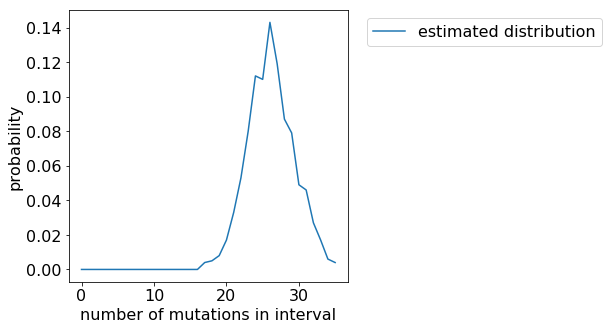

In [3]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import numpy as np
tf.enable_v2_behavior()
tfd = tfp.distributions 

from collections import Counter
from matplotlib import pyplot as plt 
%matplotlib inline 

def estimate_probability_of_number_of_mutations_in_interval(
    number_kmers,
    kmer_mutation_probabilities,
    number_samples = 1000 # number of samples to draw from each binomial distribution 
): 
    number_of_mutations_of_kmers = tfd.Binomial(
        total_count = number_kmers, 
        probs = kmer_mutation_probabilities
    ).sample(number_samples)
    
    number_of_mutations_in_interval = tf.reduce_sum(number_of_mutations_of_kmers, axis=1).numpy()
 
    counts_of_number_of_mutations_in_interval = Counter(number_of_mutations_in_interval)    
    max_number_of_mutations_in_interval = int(np.max(number_of_mutations_in_interval))
    probability_of_number_of_mutations_in_interval = np.array([
        counts_of_number_of_mutations_in_interval[value] 
        if value in counts_of_number_of_mutations_in_interval 
        else 0 
        for value in range(max_number_of_mutations_in_interval)
    ])/number_samples
    
    return max_number_of_mutations_in_interval, probability_of_number_of_mutations_in_interval
    
def analytic_distribution_of_number_of_mutations_in_interval(
    number_kmers, 
    kmer_mutation_probabilities
): 
    return tfd.Binomial(
        total_count = np.sum(number_kmers).astype('float32'), 
        probs = kmer_mutation_probabilities
    )
    
def plot_distribution_of_number_mutations_in_interval(number_kmers, kmer_mutation_probabilities):     
    max_number_of_mutations_in_interval, probability_of_number_of_mutations_in_interval = \
        estimate_probability_of_number_of_mutations_in_interval(number_kmers, kmer_mutation_probabilities)
    
    plt.figure(figsize=(5,5))
    plt.rcParams.update({'font.size': 16})    
    plt.plot(probability_of_number_of_mutations_in_interval, label='estimated distribution')
    plt.xlabel('number of mutations in interval')
    plt.ylabel('probability')

    if type(kmer_mutation_probabilities) == float:
        dist = analytic_distribution_of_number_of_mutations_in_interval(number_kmers, kmer_mutation_probabilities)
        plt.plot(dist.prob(range(max_number_of_mutations_in_interval)), label='analytic distribution')  
        
    plt.legend(loc='upper left', bbox_to_anchor=(1.04,1), fontsize=16) 
       
# suppose there are 3 distinct kmers in the genomic interval,
# each occurring the following number of times (aggregated over the sequence and all tumors) 
counts_of_three_distinct_kmers = [10, 20, 30]

plot_distribution_of_number_mutations_in_interval(
    number_kmers = counts_of_three_distinct_kmers,
    kmer_mutation_probabilities = [.4, .8, .2]
)

As a sanity check, the estimated distribution collapses onto the analytic solution in the special case of equal mutation probabilities: 

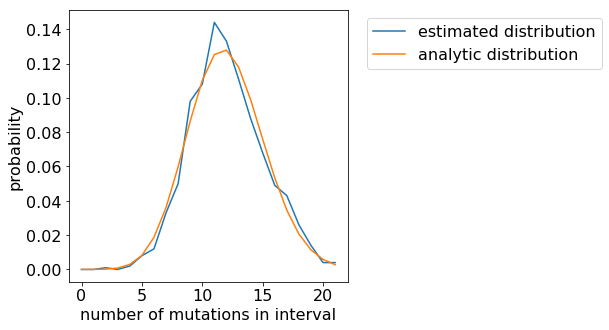

In [4]:
plot_distribution_of_number_mutations_in_interval(
    number_kmers = counts_of_three_distinct_kmers,
    kmer_mutation_probabilities = .2 # common value of all mutation probabilities
)

## Estimating the p-value of observed mutation counts in a genomic interval under the model

With the distribution in hand, it is trivial to estimate a **p-value** for an observed number of mutations in a genomic interval under this model: 

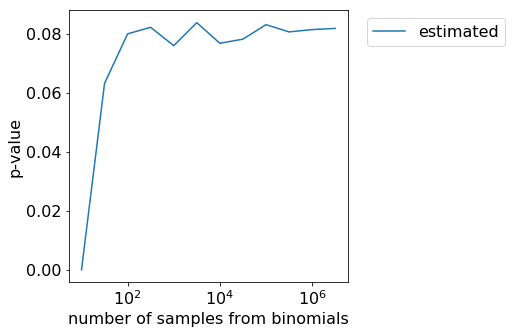

In [5]:
def compute_p_value(
    number_kmers, 
    kmer_mutation_probabilities, 
    observed_number_of_mutations_in_interval,
    number_samples
):     
    max_number_of_mutations_in_interval, probability_of_number_of_mutations_in_interval = \
        estimate_probability_of_number_of_mutations_in_interval(
        number_kmers, 
        kmer_mutation_probabilities,
        number_samples 
    )
    
    if observed_number_of_mutations_in_interval > max_number_of_mutations_in_interval: 
        return None
    else: 
        # prob(N > n) (to be consistent with TensorFlow Probability API):
        return np.sum(probability_of_number_of_mutations_in_interval[
            observed_number_of_mutations_in_interval+1:]) 
    

def plot_p_value_convergence(
    number_kmers, 
    kmer_mutation_probabilities, 
    observed_number_of_mutations_in_interval
):     
    number_samples, p_values = zip(*[
        (10**exponent, 
         compute_p_value(
             number_kmers,
             kmer_mutation_probabilities,
             observed_number_of_mutations_in_interval,
             number_samples = 10**exponent
         )) for exponent in np.arange(1, 7, 0.5)
    ])
    
    plt.figure(figsize=(5,5))
    plt.rcParams.update({'font.size': 16})    
    plt.plot(number_samples, p_values, label='estimated')
    plt.xlabel('number of samples from binomials')
    plt.ylabel('p-value')
    plt.xscale('log')
    
    if type(kmer_mutation_probabilities) == float:
        dist = analytic_distribution_of_number_of_mutations_in_interval(number_kmers, kmer_mutation_probabilities)        
        true_pvalue = 1 - dist.cdf(observed_number_of_mutations_in_interval) # prob(N > n)
        plt.plot([min(number_samples), max(number_samples)], [true_pvalue, true_pvalue], label='true')  
    
    plt.legend(loc='upper left', bbox_to_anchor=(1.04,1), fontsize=16) 

plot_p_value_convergence(
    number_kmers = counts_of_three_distinct_kmers,
    kmer_mutation_probabilities = [.4, .8, .2],
    observed_number_of_mutations_in_interval = 30
)    

Again, as a sanity check, the estimated p-value collapses onto the analytic solution in the special case of equal mutation probabilities: 

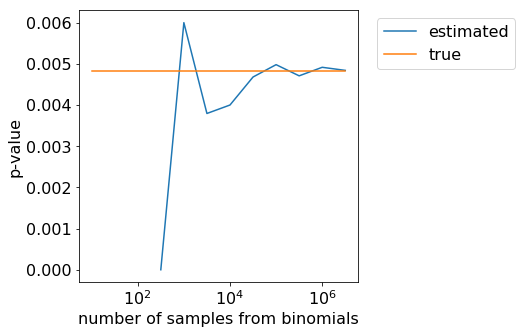

In [6]:
plot_p_value_convergence(
    number_kmers = counts_of_three_distinct_kmers,
    kmer_mutation_probabilities = .2, # common value of all mutation probabilities
    observed_number_of_mutations_in_interval = 20
)    